# Mine-Rock classifier based on Sonar data inputs

## About the dataset

The task is to train a system to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock.

**Source:** The data set was contributed to the benchmark collection by Terry Sejnowski, now at the Salk Institute and the University of California at San Deigo. The data set was developed in collaboration with R. Paul Gorman of Allied-Signal Aerospace Technology Center.

**Data Set Information:** The file "sonar.mines" contains 111 patterns obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file "sonar.rocks" contains 97 patterns obtained from rocks under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock.

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp.

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#about_dataset">About the dataset</a></li>
        <li><a href="#preprocessing">Data pre-processing and selection</a></li>
        <li><a href="#modeling">Modeling (Logistic Regression with Scikit-learn, 5 fold CV, Decision Tree)</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
    </ol>
</div>
<br>
<hr>

**Importing required libraries and packages**

In [2]:
import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import AdvancedAnalytics
from AdvancedAnalytics import ReplaceImputeEncode
from AdvancedAnalytics import logreg
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from AdvancedAnalytics import logreg

In [3]:
df = pd.read_excel("sonar3by5(1).xlsx")
df.describe(include='all')

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R52,R53,R54,R55,R56,R57,R58,R59,R60,object
count,203.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,203.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111
mean,0.029013,0.038437,0.043832,0.053892,0.079370,0.118349,0.121747,0.134799,0.177185,0.208259,...,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507,NaN
std,0.023021,0.032960,0.038428,0.046528,0.090651,0.209281,0.061788,0.085152,0.116309,0.134416,...,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031,NaN
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600,NaN
25%,0.013150,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.096750,0.111275,...,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100,NaN
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152300,0.182400,...,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300,NaN
75%,0.035800,0.047950,0.057950,0.064500,0.100275,0.134500,0.154000,0.169600,0.234050,0.268700,...,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525,NaN


In [4]:
df.isnull().sum()
df.shape

(208, 61)

**Creating map for data regarding outlier and missing value identification and imputation**

In [5]:
attribute_map={}
for i in range(60):
    str = 'R'+"%i" %(i+1)
    attribute_map[str]=['I',(0,1)]

attribute_map['object'] = ['B',('M', 'R')]

**Replacing the outliers, imputing the missing values and ecoding the datafram**

In [6]:
rie = ReplaceImputeEncode(data_map=attribute_map, display=True)
encoded_df = rie.fit_transform(df)


********** Data Preprocessing ***********
Features Dictionary Contains:
60 Interval, 
1 Binary, 
0 Nominal, and 
0 Excluded Attribute(s).

Data contains 208 observations & 61 columns.


Attribute Counts
............. Missing  Outliers
R1......         5         0
R2......         0         0
R3......         0         0
R4......         0         0
R5......         0         1
R6......         0         1
R7......         0         0
R8......         0         0
R9......         5         0
R10.....         0         0
R11.....         0         0
R12.....         0         0
R13.....         0         0
R14.....         0         0
R15.....         0         0
R16.....         5         0
R17.....         0         0
R18.....         0         0
R19.....         0         1
R20.....         0         0
R21.....         0         0
R22.....         0         0
R23.....         0         0
R24.....         0         0
R25.....         0         0
R26.....         0         0
R27.....  

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


**Performing Logistics Regression**

In [7]:
y = np.asarray(encoded_df['object'])
X = np.asarray(encoded_df.drop('object', axis=1))
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X,y,test_size = 0.3, random_state=7)
lgr_train = LogisticRegression()
lgr_train.fit(X_train, y_train)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

**Evaluation of Logistic Regression Model**

In [8]:
print("\nTraining Data\nRandom Selection of 70% of Original Data")
logreg.display_binary_split_metrics(lgr_train, X_train, y_train,X_validate, y_validate)


Training Data
Random Selection of 70% of Original Data


Model Metrics..........       Training     Validation
Observations...........            145             63
Coefficients...........             61             61
DF Error...............             84              2
Mean Absolute Error....         0.3338         0.3741
Avg Squared Error......         0.1399         0.1724
Accuracy...............         0.8345         0.7778
Precision..............         0.8571         0.7692
Recall (Sensitivity)...         0.7826         0.7143
F1-score...............         0.8182         0.7407
MISC (Misclassification)...      16.6%          22.2%
     class 0...............      11.8%          17.1%
     class 1...............      21.7%          28.6%


Training
Confusion Matrix  Class 0   Class 1  
Class 0.....        67         9
Class 1.....        15        54


Validation
Confusion Matrix  Class 0   Class 1  
Class 0.....        29         6
Class 1.....         8        20


In [9]:
y_hat=lgr_train.predict(X_validate)
y_hat

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

**Performing 5 fold Cross Validation and its evaluation** 

In [21]:
from sklearn.model_selection import cross_val_score
lgr_4_scores = cross_val_score(lgr_train, X_train, y_train, cv=5)
print("\nAccuracy Scores by Fold: ", lgr_4_scores)
print("Accuracy Mean: %.4f" %lgr_4_scores.mean())
print("Accuracy Std. Dev.: %.4f" %lgr_4_scores.std())


Accuracy Scores by Fold:  [0.93333333 0.5862069  0.75862069 0.65517241 0.78571429]
Accuracy Mean: 0.7438
Accuracy Std. Dev.: 0.1188


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

**Building a Classification Decision Tree**

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
sonartree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
sonartree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
sonartree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
predtree = sonartree.predict(X_validate)

**Evaluation**

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: " , metrics.accuracy_score(y_validate, predtree))

DecisionTrees's Accuracy:  0.8412698412698413


**Tree Visualization**

In [16]:
 !conda install -c conda-forge pydotplus -y
 !conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |             py_2          23 KB  conda-forge
    cryptography-2.4.2         |   py36h1ba5d50_0         618 KB
    openssl-1.1.1a             |    h14c3975_1000         4.0 MB  conda-forge
    libarchive-3.3.3           |       h5d8350f_5         1.5 MB
    grpcio-1.16.1              |   py36hf8bcb03_1         1.1 MB
    conda-4.6.2                |           py36_0         869 KB  conda-forge
    libssh2-1.8.0              |                1         239 KB  conda-forge
    python-3.6.8               |       h0371630_0        34.4 MB
    ------------------------------------------------------------
                                           Total:        42.6 MB

The following 

In [17]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

In [18]:
dot_data = StringIO()
filename = "sonartree.png"
featureNames = df.columns[0:60]
targetNames = df["object"].unique().tolist()

out=tree.export_graphviz(sonartree,feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True,rotate=False)  



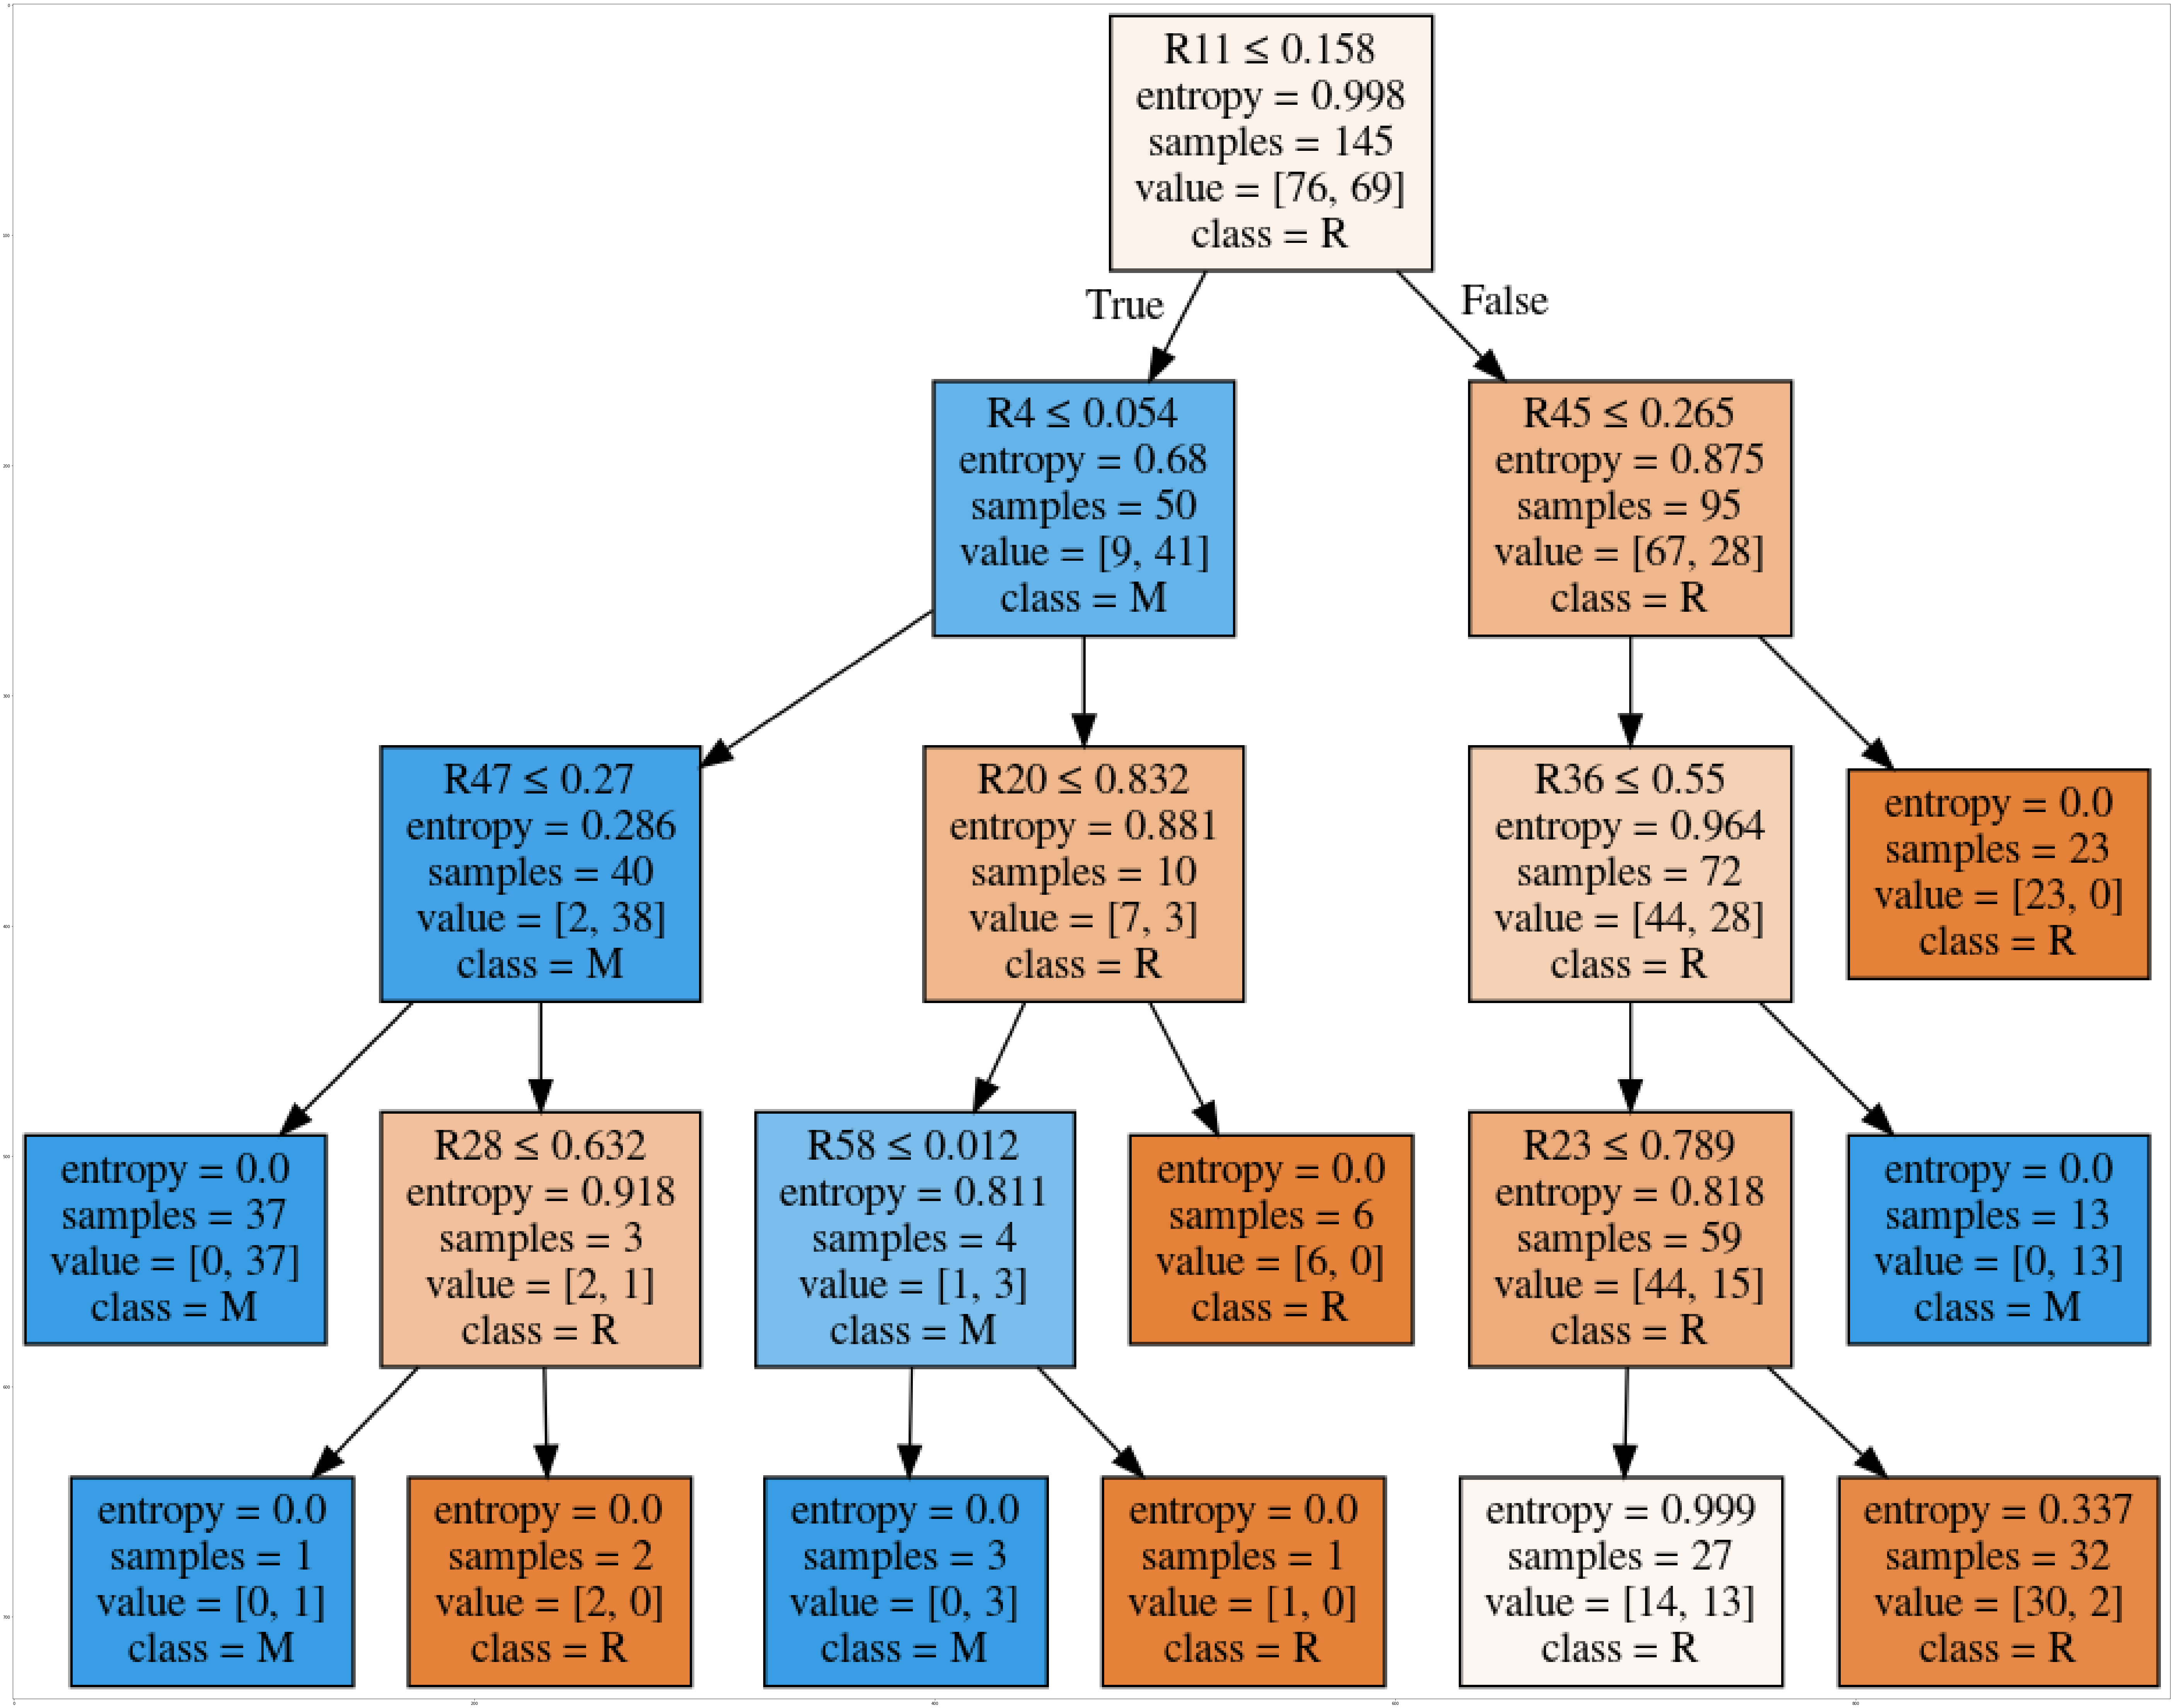

In [20]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

**The Decision Tree results in the highest Accuracy for the model : 84.12%**